In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.0
MESH_SIZE   = 100

POPSIZE         = 100
MAX_STREE_DEPTH = 5
GENERATIONS     = 25
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

LIBSIZE      = 2000
LIB_MAXDEPTH = 3

RANDSTATE = 124

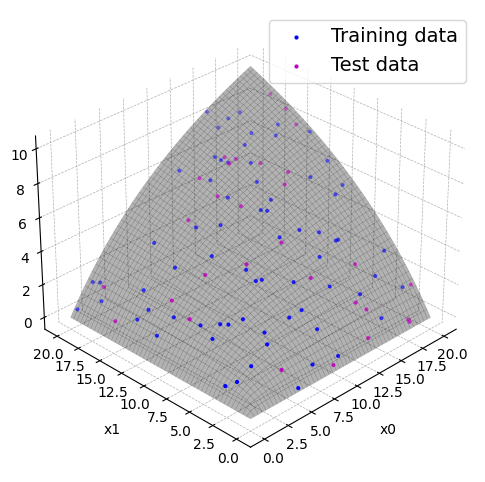

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, X_mesh, LIBSIZE, LIB_MAXDEPTH)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/24 [00:00<?, ?it/s]

         826119 function calls (708448 primitive calls) in 2.592 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2400    0.050    0.000    2.588    0.001 corrector.py:21(correct)
     2396    0.077    0.000    1.191    0.000 library.py:423(cquery)
     2400    0.035    0.000    0.987    0.000 corrector.py:60(backprop_know)
     3811    0.009    0.000    0.768    0.000 library.py:76(query)
     3811    0.547    0.000    0.759    0.000 _kdtree.py:363(query)
42636/7773    0.093    0.000    0.364    0.000 binop.py:27(__getitem__)
14052/4792    0.014    0.000    0.295    0.000 syntax_tree.py:139(pull_know_deriv)
9542/4194    0.209    0.000    0.290    0.000 binop.py:292(pull_know_deriv)
     8502    0.051    0.000    0.260    0.000 constraints.py:35(match_key)
     8487    0.020    0.000    0.209    0.000 <__array_function__ internals>:177(array_equal)
     8487    0.100    0.000    0.186    0.000 numeric.py:2407(array_eq

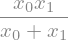

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

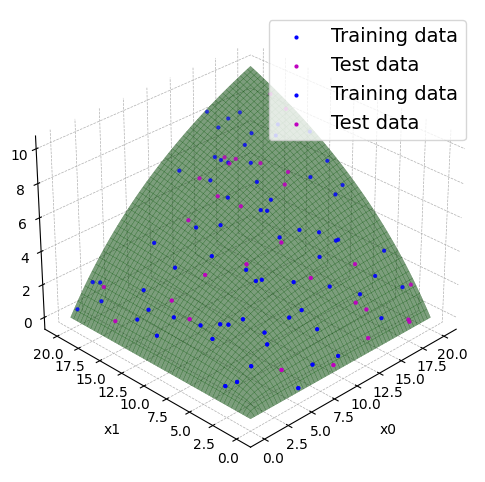

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

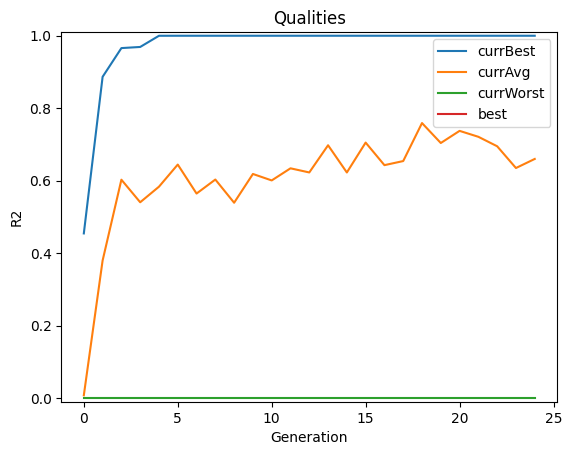

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

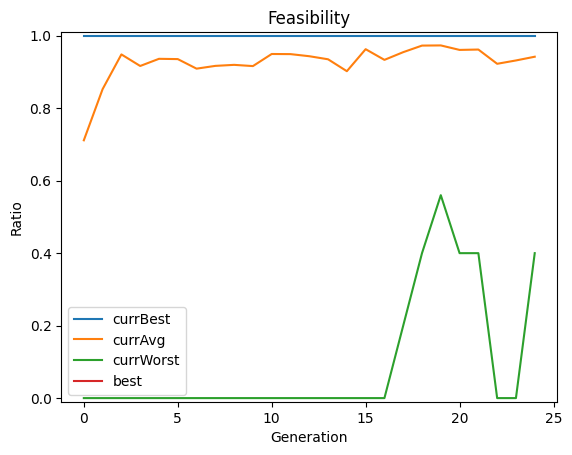

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

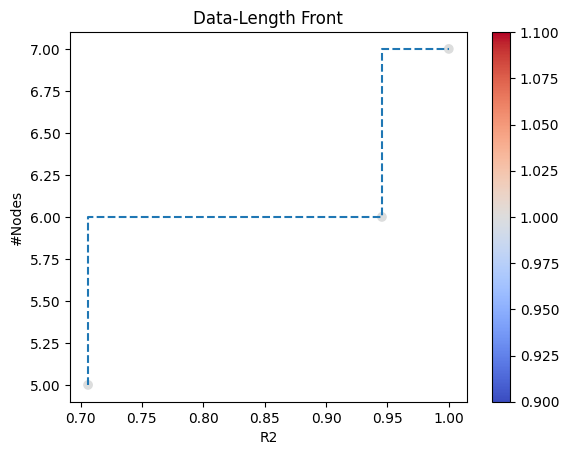

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(x1 * (x0 * 0.04)),0,0.141231,0.706156,5,(*),1,inf
1,1,((x0 * x1) / (x1 + x0)),0,0.142857,1.000000,7,"(/, *, +)",1,inf
2,2,sqrt(((0.20 * x1) * x0)),0,0.157589,0.945534,6,"(sqrt, *)",1,2.000000
3,0,(((x0 * 0.04) * x1) / 0.98),1,0.096606,0.676239,7,(*),1,inf
4,1,(x0 / ((x0 / x1) + (x1 / x1))),1,0.111111,1.000000,9,"(/, +)",1,inf
5,2,(x0 / (exp(-0.18) + (x0 / x1))),1,0.121108,0.968867,8,"(/, exp, +)",1,2.000000
6,0,(((x0 / x1) * square(x1)) / (x0 + x1)),2,0.100000,1.000000,10,"(/, square, *, +)",1,inf
7,1,sqrt((square(-0.61) * (x0 * x1))),2,0.093811,0.656680,7,"(square, sqrt, *)",1,inf
8,2,(x1 / (exp(-0.18) + (x1 / x0))),2,0.120716,0.965725,8,"(/, exp, +)",1,1.664254
9,3,(((x0 * 0.99) * x1) / (x1 + x0)),2,0.111019,0.999172,9,"(/, *, +)",1,0.766501


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)